In [1]:
def load_datasets_from_zenodo():
    """Load all datasets directly from Zenodo URLs"""
    
    urls = {
        "cell_poi": "https://zenodo.org/records/10142719/files/cell_POIcat.csv.gz",
        "dataset2": "https://zenodo.org/records/10142719/files/yjmob100k-dataset2.csv.gz",
        "poi_categories": "https://zenodo.org/records/10836269/files/POI_datacategories.csv"
    }
    
    def read_gzipped_csv_from_url(url):
        """Read a gzipped CSV file from URL"""
        print(f"Downloading from {url}...")
        response = requests.get(url)
        response.raise_for_status()
        
        with gzip.open(BytesIO(response.content), 'rt') as f:
            df = pd.read_csv(f)
        return df
    
    def read_csv_from_url(url):
        """Read a regular CSV file from URL"""
        print(f"Downloading from {url}...")
        response = requests.get(url)
        response.raise_for_status()
        
        df = pd.read_csv(BytesIO(response.content))
        return df
    
    # Load datasets
    print("Loading datasets from Zenodo...")
    
    cell_poi_df = read_gzipped_csv_from_url(urls["cell_poi"])
    print(f"✓ Cell POI data loaded: {cell_poi_df.shape}")
    
    dataset2_df = read_gzipped_csv_from_url(urls["dataset2"])
    print(f"✓ Dataset 2 loaded: {dataset2_df.shape}")
    
    poi_categories_df = read_csv_from_url(urls["poi_categories"])
    print(f"✓ POI categories loaded: {poi_categories_df.shape}")
    
    return cell_poi_df, dataset2_df, poi_categories_df

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
import gzip
from collections import defaultdict
import pickle
import os

In [3]:
# ============================================================================
# TIME ANALYSIS FUNCTIONS
# ============================================================================

def add_time_analysis(df):
    """Add time-based analysis to mobility data"""
    
    def convert_timeslot(t):
        hours = t // 2
        minutes = (t % 2) * 30
        return f"{hours:02d}:{minutes:02d}"

    def get_time_of_day(t):
        if 0 <= t < 12: return "early_morning"
        elif 12 <= t < 24: return "morning"
        elif 24 <= t < 36: return "afternoon"
        else: return "evening"
    
    df['time'] = df['t'].apply(convert_timeslot)
    df['time_of_day'] = df['t'].apply(get_time_of_day)
    
    return df

def split_normal_emergency_periods(df, threshold_day=60):
    """Split data into normal and emergency periods"""
    normal_data = df[df['d'] <= threshold_day].copy()
    emergency_data = df[df['d'] > threshold_day].copy()
    
    print(f"Normal period data: {len(normal_data)} records")
    print(f"Emergency period data: {len(emergency_data)} records")
    
    return normal_data, emergency_data

In [4]:
# ============================================================================
# POI MAPPING FUNCTIONS (UNCHANGED)
# ============================================================================

def create_poi_function_mapping():
    """Create mapping from POI categories to functional groups"""
    
    poi_function_mapping = {
        # Food & Dining
        'Food': 'food_dining',
        'Japanese restaurant': 'food_dining',
        'Western restaurant': 'food_dining',
        'Eat all you can restaurant': 'food_dining',
        'Chinese restaurant': 'food_dining',
        'Indian restaurant': 'food_dining',
        'Ramen restaurant': 'food_dining',
        'Curry restaurant': 'food_dining',
        'BBQ restaurant': 'food_dining',
        'Hot pot restaurant': 'food_dining',
        'Bar': 'food_dining',
        'Diner': 'food_dining',
        'Creative cuisine': 'food_dining',
        'Organic cuisine': 'food_dining',
        'Pizza': 'food_dining',
        'Café': 'food_dining',
        'Tea Salon': 'food_dining',
        'Bakery': 'food_dining',
        'Sweets': 'food_dining',
        'Wine Bar': 'food_dining',
        'Pub': 'food_dining',
        'Beer Garden': 'food_dining',
        'Fast Food': 'food_dining',
        'Theme Park Restaurant': 'food_dining',
        'Amusement Restaurant': 'food_dining',
        'Other Restaurants': 'food_dining',
        
        # Entertainment & Recreation
        'Entertainment': 'entertainment_recreation',
        'Disco': 'entertainment_recreation',
        'Karaoke': 'entertainment_recreation',
        'Cruising': 'entertainment_recreation',
        'Sports Recreation': 'entertainment_recreation',
        'Game Arcade': 'entertainment_recreation',
        'Swimming Pool': 'entertainment_recreation',
        'Park': 'entertainment_recreation',
        'Casino': 'entertainment_recreation',
        'Fishing': 'entertainment_recreation',
        'Hot Spring': 'entertainment_recreation',
        
        # Shopping & Retail
        'Shopping': 'shopping_retail',
        'Glasses': 'shopping_retail',
        'Drug Store': 'shopping_retail',
        'Electronics Store': 'shopping_retail',
        'DIY Store': 'shopping_retail',
        'Convenience Store': 'shopping_retail',
        'Recycle Shop': 'shopping_retail',
        'Interior Shop': 'shopping_retail',
        'Sports Store': 'shopping_retail',
        'Clothes Store': 'shopping_retail',
        'Grocery Store': 'shopping_retail',
        'Online Grocery Store': 'shopping_retail',
        'Home Appliances': 'shopping_retail',
        'Retail Store': 'shopping_retail',
        'Building Material': 'shopping_retail',
        'Gardening': 'shopping_retail',
        
        # Transportation
        'Transit Station': 'transportation',
        'Parking Area': 'transportation',
        'Port': 'transportation',
        
        # Services
        'Hospital': 'services',
        'Pharmacy': 'services',
        'Chiropractic': 'services',
        'Elderly Care Home': 'services',
        'Post Office': 'services',
        'Laundry': 'services',
        'Driving School': 'services',
        'Wedding Ceremony': 'services',
        'Cemetary': 'services',
        'Bank': 'services',
        'Vet': 'services',
        'Hair Salon': 'services',
        'Lawyer Office': 'services',
        'Recruitment Office': 'services',
        'City Hall': 'services',
        'Community Center': 'services',
        'Accountant Office': 'services',
        'Utility Company': 'services',
        
        # Business & Industrial
        'IT Office': 'business_industrial',
        'Publisher Office': 'business_industrial',
        'Heavy Industry': 'business_industrial',
        'Research Facility': 'business_industrial',
        'Real Estate': 'business_industrial',
        
        # Education & Culture
        'School': 'education_culture',
        'Cram School': 'education_culture',
        'Kindergarten': 'education_culture',
        
        # Accommodation
        'Hotel': 'accommodation',
        
        # Religious & Community
        'Church': 'religious_community',
        'NPO': 'religious_community',
    }
    
    return poi_function_mapping

In [5]:
def create_id_to_function_mapping(poi_categories_df):
    """Create direct mapping from category IDs to functional groups"""
    
    category_to_function = create_poi_function_mapping()
    id_to_function = {}
    
    # Check the actual structure of the POI categories dataframe
    print("POI Categories DataFrame columns:", poi_categories_df.columns.tolist())
    print("POI Categories DataFrame shape:", poi_categories_df.shape)
    print("First few rows:")
    print(poi_categories_df.head())
    
    # Handle different possible structures
    if 'id' in poi_categories_df.columns and 'category' in poi_categories_df.columns:
        # Original expected structure
        for _, row in poi_categories_df.iterrows():
            category_id = row['id']
            category_name = row['category']
            
            if category_name in category_to_function:
                id_to_function[category_id] = category_to_function[category_name]
            else:
                id_to_function[category_id] = 'other'
    
    elif len(poi_categories_df.columns) == 1:
        # Single column with category names - create sequential IDs
        category_column = poi_categories_df.columns[0]
        for idx, category_name in enumerate(poi_categories_df[category_column]):
            category_id = idx + 1  # Start IDs from 1
            
            if category_name in category_to_function:
                id_to_function[category_id] = category_to_function[category_name]
            else:
                id_to_function[category_id] = 'other'
    
    else:
        # Try to find category names in the first column
        first_col = poi_categories_df.columns[0]
        for idx, category_name in enumerate(poi_categories_df[first_col]):
            category_id = idx + 1
            
            if category_name in category_to_function:
                id_to_function[category_id] = category_to_function[category_name]
            else:
                id_to_function[category_id] = 'other'
    
    return id_to_function


In [6]:
# ============================================================================
# POI ANALYSIS FUNCTIONS
# ============================================================================

def enhance_poi_data(cell_poi_df, poi_categories_df):
    """Enhance POI data with functional groups and proportions"""
    
    try:
        # Create ID to function mapping
        id_to_function = create_id_to_function_mapping(poi_categories_df)
        
        # Check POI data structure
        print("Cell POI DataFrame columns:", cell_poi_df.columns.tolist())
        print("Cell POI DataFrame shape:", cell_poi_df.shape)
        print("First few rows of Cell POI:")
        print(cell_poi_df.head())
        
        # Create a copy of cell_poi_df to work with
        enhanced_poi_df = cell_poi_df.copy()
        
        # Create category mapping dataframe
        if len(poi_categories_df.columns) == 1:
            # Single column with category names
            category_column = poi_categories_df.columns[0]
            category_mapping = pd.DataFrame({
                'id': range(1, len(poi_categories_df) + 1),
                'category': poi_categories_df[category_column].values
            })
        else:
            # Assume first column has category names
            first_col = poi_categories_df.columns[0]
            category_mapping = pd.DataFrame({
                'id': range(1, len(poi_categories_df) + 1),
                'category': poi_categories_df[first_col].values
            })
        
        # Merge with category mapping
        enhanced_poi_df = pd.merge(
            enhanced_poi_df,
            category_mapping,
            left_on='POIcategory',
            right_on='id',
            how='left'
        )
        
        # Add functional group based on category ID
        enhanced_poi_df['functional_group'] = enhanced_poi_df['POIcategory'].map(
            lambda x: id_to_function.get(x, 'other')
        )
        
        # Calculate total POI count for each cell
        cell_total_counts = enhanced_poi_df.groupby(['x', 'y'])['POI_count'].sum().reset_index()
        cell_total_counts.rename(columns={'POI_count': 'total_poi_count'}, inplace=True)
        
        # Merge total counts back
        enhanced_poi_df = enhanced_poi_df.merge(cell_total_counts, on=['x', 'y'], how='left')
        
        # Calculate proportions
        enhanced_poi_df['poi_proportion'] = enhanced_poi_df['POI_count'] / enhanced_poi_df['total_poi_count']
        
        print(f"Enhanced POI data created: {enhanced_poi_df.shape}")
        print("New columns added:", [col for col in enhanced_poi_df.columns if col not in cell_poi_df.columns])
        
        return enhanced_poi_df
        
    except Exception as e:
        print(f"Error enhancing POI data: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_functional_regions(enhanced_poi_df):
    """Create functional regions based on POI distribution"""
    
    try:
        functional_regions = {}
        
        # Group by cell coordinates
        for (x, y), group in enhanced_poi_df.groupby(['x', 'y']):
            # Calculate function distribution
            function_counts = group.groupby('functional_group')['POI_count'].sum().to_dict()
            
            # Calculate function proportions
            total_count = sum(function_counts.values())
            function_proportions = {func: count/total_count for func, count in function_counts.items()}
            
            # Determine leading function
            leading_function = max(function_proportions.items(), key=lambda x: x[1])[0]
            
            # Store region information
            functional_regions[(x, y)] = {
                'poi_counts': function_counts,
                'function_proportions': function_proportions,
                'leading_function': leading_function,
                'total_poi_count': total_count,
                'poi_categories': group['category'].tolist(),
                'poi_category_counts': group.groupby('category')['POI_count'].sum().to_dict()
            }
        
        print(f"Created {len(functional_regions)} functional regions")
        
        # Count regions by leading function
        leading_function_counts = defaultdict(int)
        for region_info in functional_regions.values():
            leading_function_counts[region_info['leading_function']] += 1
        
        print("Distribution of leading functions across regions:")
        for func, count in leading_function_counts.items():
            print(f"  {func}: {count} regions ({count/len(functional_regions)*100:.1f}%)")
        
        return functional_regions
        
    except Exception as e:
        print(f"Error creating functional regions: {e}")
        return {}

In [7]:
# ============================================================================
# VISUALIZATION FUNCTIONS (MODIFIED FOR AZURE)
# ============================================================================

def visualize_functional_regions(enhanced_poi_df, functional_regions, save_path="./"):
    """Create visualizations of functional regions"""
    
    try:
        # Create color mapping for functional groups
        function_colors = {
            'food_dining': 'red',
            'shopping_retail': 'blue',
            'entertainment_recreation': 'green',
            'transportation': 'yellow',
            'services': 'purple',
            'business_industrial': 'brown',
            'education_culture': 'pink',
            'residential': 'gray',
            'accommodation': 'orange',
            'religious_community': 'cyan',
            'other': 'black'
        }
        
        # Prepare data for plotting
        x_coords = []
        y_coords = []
        colors = []
        sizes = []
        
        for (x, y), region_info in functional_regions.items():
            x_coords.append(x)
            y_coords.append(y)
            func = region_info['leading_function']
            color = function_colors.get(func, 'black')
            colors.append(color)
            sizes.append(30 + region_info['total_poi_count'] * 2)
        
        # Create scatter plot
        plt.figure(figsize=(12, 10))
        plt.scatter(x_coords, y_coords, c=colors, s=sizes, alpha=0.7)
        plt.grid(True, alpha=0.3)
        
        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                   label=function, markersize=10)
            for function, color in function_colors.items()
            if function in [info['leading_function'] for info in functional_regions.values()]
        ]
        
        plt.legend(handles=legend_elements, title="Functional Groups", 
                   loc='upper right', bbox_to_anchor=(1.1, 1))
        
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Functional Regions by Leading Function')
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'{save_path}functional_regions.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Function distribution bar chart
        plt.figure(figsize=(12, 6))
        
        leading_function_counts = defaultdict(int)
        for region_info in functional_regions.values():
            leading_function_counts[region_info['leading_function']] += 1
        
        functions = list(leading_function_counts.keys())
        counts = list(leading_function_counts.values())
        colors_for_bar = [function_colors.get(f, 'black') for f in functions]
        
        plt.bar(functions, counts, color=colors_for_bar)
        plt.xlabel('Functional Group')
        plt.ylabel('Number of Regions')
        plt.title('Distribution of Leading Functions Across Regions')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        plt.savefig(f'{save_path}function_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create heatmap
        plt.figure(figsize=(12, 10))
        
        # Get grid dimensions
        max_x = max(enhanced_poi_df['x'])
        max_y = max(enhanced_poi_df['y'])
        
        # Initialize grid
        grid = np.full((max_x + 1, max_y + 1), -1)
        
        # Get unique functions and create mapping
        all_functions = set()
        for region_info in functional_regions.values():
            all_functions.add(region_info['leading_function'])
        
        function_indices = {func: i for i, func in enumerate(sorted(all_functions))}
        
        # Fill grid
        for (x, y), region_info in functional_regions.items():
            func = region_info['leading_function']
            grid[int(x), int(y)] = function_indices[func]
        
        # Create masked array
        masked_grid = np.ma.masked_where(grid < 0, grid)
        
        # Plot heatmap
        cmap = plt.cm.viridis
        cmap.set_bad('white', 1)
        
        plt.imshow(masked_grid.T, cmap=cmap, interpolation='nearest', origin='lower')
        
        # Add colorbar
        cbar = plt.colorbar(ticks=range(len(function_indices)))
        cbar.set_ticklabels(list(function_indices.keys()))
        
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title('Functional Region Heatmap')
        plt.tight_layout()
        
        plt.savefig(f'{save_path}functional_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Visualizations created successfully!")
        
    except Exception as e:
        print(f"Error creating visualizations: {e}")
        import traceback
        traceback.print_exc()

In [8]:
# ============================================================================
# MAIN ANALYSIS FUNCTION
# ============================================================================

def run_complete_analysis():
    """Run the complete POI analysis pipeline"""
    
    print("=" * 60)
    print("STARTING COMPLETE POI FUNCTIONAL ANALYSIS")
    print("=" * 60)
    
    # 1. Load datasets from Zenodo
    cell_poi_df, dataset2_df, poi_categories_df = load_datasets_from_zenodo()
    
    # 2. Add time analysis to mobility data
    print("\nAdding time analysis to mobility datasets...")

    dataset2_df = add_time_analysis(dataset2_df)
    
    # 3. Split into normal and emergency periods
    print("\nSplitting mobility data into normal and emergency periods...")
    normal_data_2, emergency_data_2 = split_normal_emergency_periods(dataset2_df)
    
    # 4. Create ID to function mapping
    id_to_function = create_id_to_function_mapping(poi_categories_df)
    
    print(f"\nPOI Category mappings created: {len(id_to_function)} categories mapped")
    
    # Count by functional group
    function_counts = defaultdict(int)
    for function in id_to_function.values():
        function_counts[function] += 1
    
    print("\nPOI categories by functional group:")
    for function, count in function_counts.items():
        print(f"  {function}: {count} categories")
    
    # 5. Enhance POI data
    print("\nEnhancing POI data with functional groups...")
    enhanced_poi_df = enhance_poi_data(cell_poi_df, poi_categories_df)
    
    if enhanced_poi_df is not None:
        # 6. Create functional regions
        print("\nCreating functional regions...")
        functional_regions = create_functional_regions(enhanced_poi_df)
        
        # 7. Create visualizations
        print("\nCreating visualizations...")
        visualize_functional_regions(enhanced_poi_df, functional_regions)
        
        # 8. Save results (in memory for Azure notebooks)
        print("\nSaving results...")
        
        # Save to pickle format that can be downloaded
        results = {
            'enhanced_poi_df': enhanced_poi_df,
            'functional_regions': functional_regions,
            'id_to_function_mapping': id_to_function,
            'normal_data_2': normal_data_2,
            'emergency_data_2': emergency_data_2
        }
        
        # Save as pickle file
        with open('complete_analysis_results.pkl', 'wb') as f:
            pickle.dump(results, f)
            
        # Save enhanced POI data as CSV
        enhanced_poi_df.to_csv('enhanced_poi_data.csv', index=False)
        
        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE!")
        print("=" * 60)
        print("Files created:")
        print("- complete_analysis_results.pkl (all results)")
        print("- enhanced_poi_data.csv (enhanced POI dataset)")
        print("- functional_regions.png (scatter plot)")
        print("- function_distribution.png (bar chart)")
        print("- functional_heatmap.png (heatmap)")
        
        return results
    
    else:
        print("Error: Could not enhance POI data. Analysis stopped.")
        return None


STARTING COMPLETE POI FUNCTIONAL ANALYSIS
Loading datasets from Zenodo...
✓ Cell POI data loaded: (221159, 4)
✓ Dataset 2 loaded: (29389749, 5)
✓ POI categories loaded: (84, 1)

Adding time analysis to mobility datasets...

Splitting mobility data into normal and emergency periods...
Normal period data: 24384555 records
Emergency period data: 5005194 records
POI Categories DataFrame columns: ['Food']
POI Categories DataFrame shape: (84, 1)
First few rows:
                         Food
0                    Shopping
1               Entertainment
2         Japanese restaurant
3          Western restaurant
4  Eat all you can restaurant

POI Category mappings created: 84 categories mapped

POI categories by functional group:
  shopping_retail: 16 categories
  entertainment_recreation: 11 categories
  food_dining: 24 categories
  other: 3 categories
  accommodation: 1 categories
  transportation: 3 categories
  services: 16 categories
  education_culture: 3 categories
  business_industrial: 

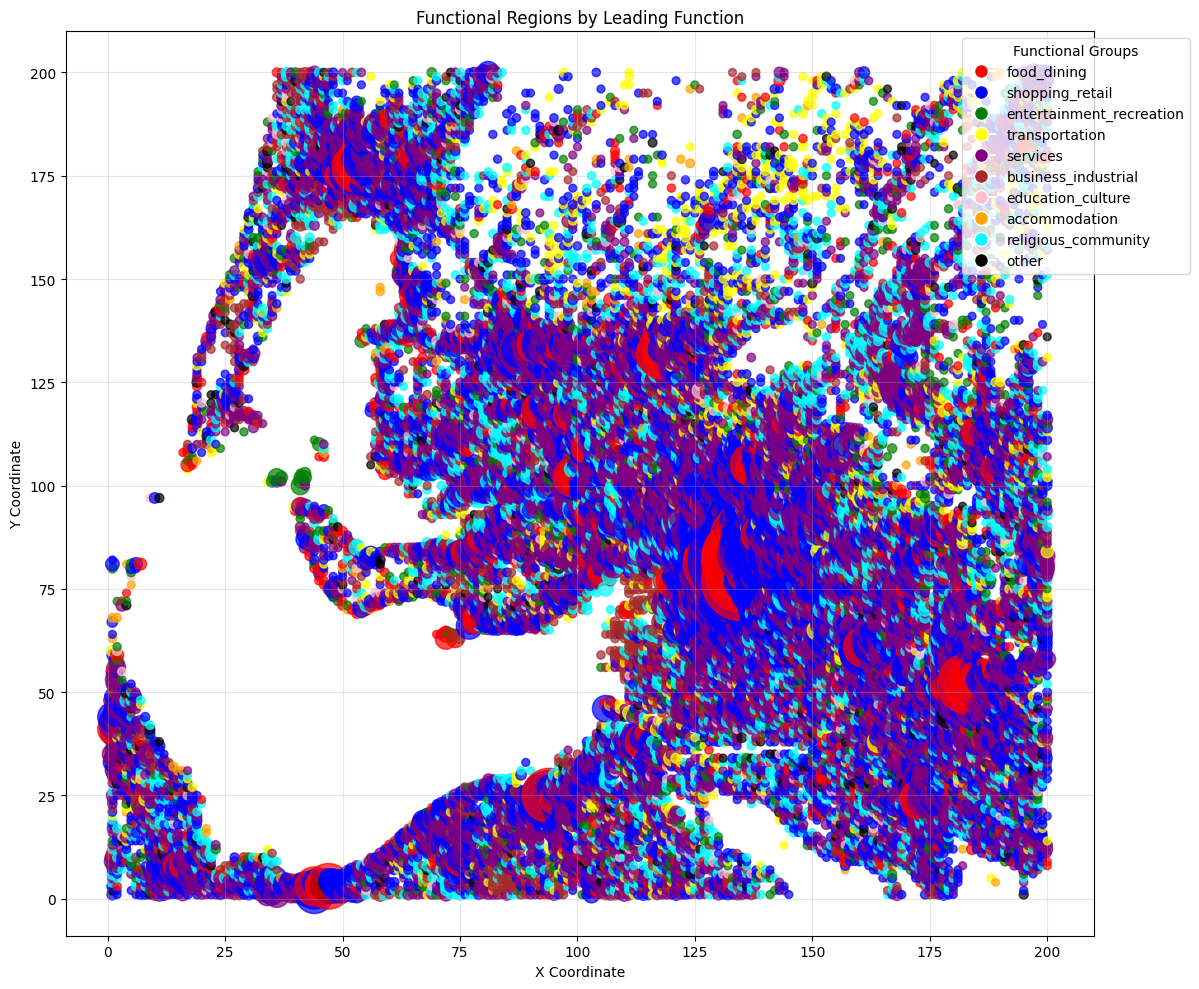

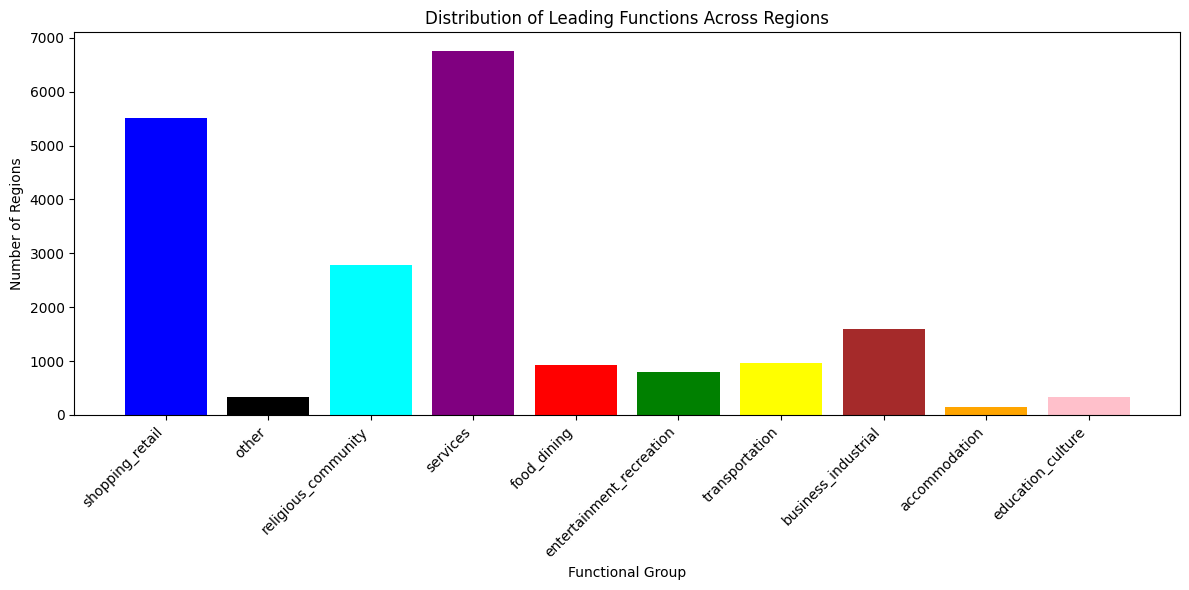

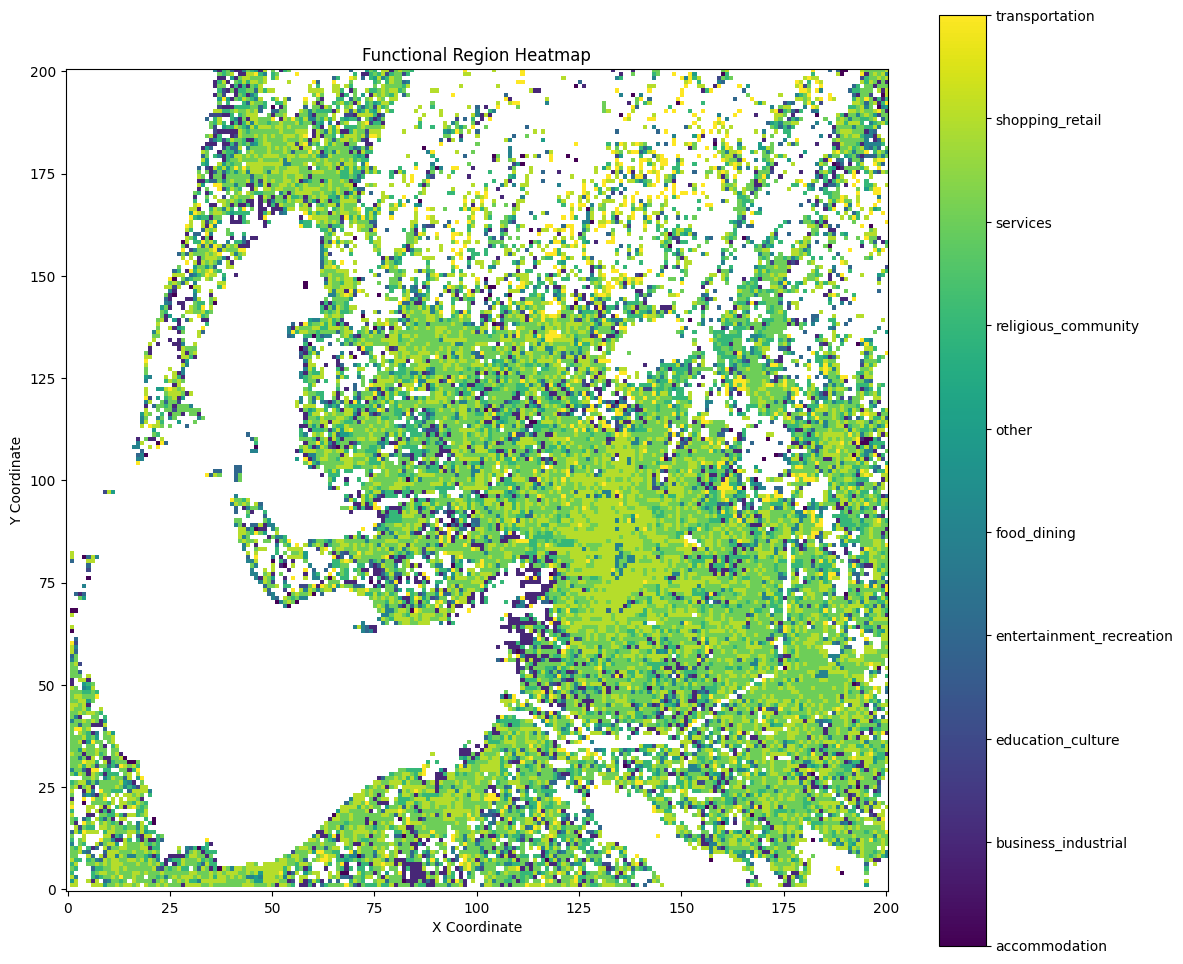

Visualizations created successfully!

Saving results...

ANALYSIS COMPLETE!
Files created:
- complete_analysis_results.pkl (all results)
- enhanced_poi_data.csv (enhanced POI dataset)
- functional_regions.png (scatter plot)
- function_distribution.png (bar chart)
- functional_heatmap.png (heatmap)


In [9]:
results = run_complete_analysis()